##**DATA PREPARATION**


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
file_path = 'data_by_genres.csv'data = pd.read_csv(file_path)

##**DATA PREPROCESSING**

In [ ]:
# Step Data Cleaning
data = data.dropna()
print(f"Data after cleaning: {data.shape}")

Data after cleaning: (2973, 14)


In [ ]:
# Menghapus duplikasi
data = data.drop_duplicates()
print(f"Data after removing duplicates: {data.shape}")

Data after removing duplicates: (2973, 14)


##**EXPLORATORY DATA ANALYSIS (EDA)**


In [ ]:
# Menampilkan informasi dataset setelah pembersihan
print("Dataset Info after Cleaning:")
print(data.info())

Dataset Info after Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mode              2973 non-null   int64  
 1   genres            2973 non-null   object 
 2   acousticness      2973 non-null   float64
 3   danceability      2973 non-null   float64
 4   duration_ms       2973 non-null   float64
 5   energy            2973 non-null   float64
 6   instrumentalness  2973 non-null   float64
 7   liveness          2973 non-null   float64
 8   loudness          2973 non-null   float64
 9   speechiness       2973 non-null   float64
 10  tempo             2973 non-null   float64
 11  valence           2973 non-null   float64
 12  popularity        2973 non-null   float64
 13  key               2973 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 325.3+ KB
None


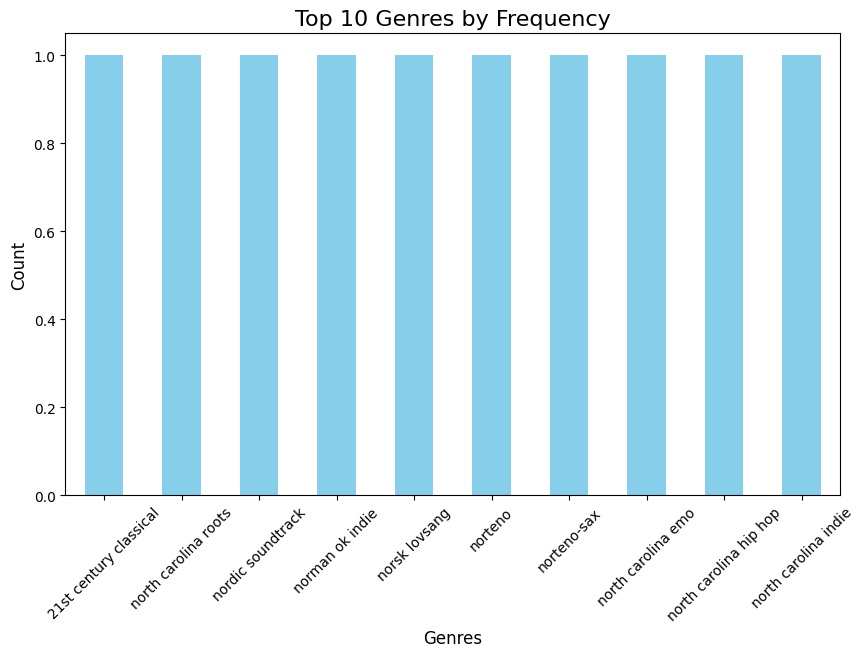

In [ ]:
# Top 10 genres (visualisasi awal)
top_genres = data['genres'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.title('Top 10 Genres by Frequency', fontsize=16)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

##**FEATURE ENGINEERING**


In [ ]:
# Features yang digunakan untuk rekomendasi
features = ['acousticness', 'danceability', 'energy', 'liveness',
            'speechiness', 'valence', 'tempo', 'popularity']

In [ ]:
# Standarisasi data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

##**USER PREFERENCES**

In [ ]:
# Simulasi Preferensi Pengguna
# Misalkan pengguna lebih suka genre tertentu (contoh: "pop", "rock") dan lagu populer
user_preferences = {
    "preferred_genres": ["pop", "rock"],  # Genre favorit pengguna
    "popularity_weight": 2.0,  # Bobot untuk fitur popularitas
    "feature_weights": [1, 1, 1, 1, 1, 1, 1, 2.0],  # Bobot fitur lainnya
}

In [ ]:
# Adjust fitur berdasarkan preferensi pengguna
def adjust_features(data_scaled, data, user_preferences):
    genre_mask = data['genres'].apply(lambda x: any(genre in x for genre in user_preferences["preferred_genres"]))
    adjusted_data = data_scaled.copy()

    # Tambahkan bobot untuk popularitas
    adjusted_data[:, -1] *= user_preferences["popularity_weight"]  # Fitur terakhir = popularity

    # Normalisasi ulang berdasarkan preferensi fitur
    adjusted_data *= np.array(user_preferences["feature_weights"])

    # Prioritaskan lagu dengan genre favorit
    adjusted_data[~genre_mask, :] *= 0.5  # Penalti untuk lagu yang bukan genre favorit

    return adjusted_data

data_scaled_adjusted = adjust_features(data_scaled, data, user_preferences)

##**DATA MODELLING**


In [ ]:
# Model Nearest Neighbors dengan fitur yang telah disesuaikan
nn_model = NearestNeighbors(n_neighbors=6, metric='euclidean')
nn_model.fit(data_scaled_adjusted)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [ ]:
# Fungsi untuk mendapatkan rekomendasi
def recommend_songs_personalized(song_index, data, model, features_scaled):
    distances, indices = model.kneighbors([features_scaled[song_index]])
    recommended_indices = indices[0][1:]  # Skip the first (input song itself)
    recommended_songs = data.iloc[recommended_indices][['genres', 'popularity']]
    return recommended_indices, recommended_songs

##**MODEL EVALUATION**


In [ ]:
# Contoh: Rekomendasi untuk lagu pertama di dataset
sample_index = 0
print("Song to Recommend For:", data.iloc[sample_index]['genres'])
recommended_indices, recommendations = recommend_songs_personalized(sample_index, data, nn_model, data_scaled_adjusted)
print("Recommended Songs:")
print(recommendations)

Song to Recommend For: 21st century classical
Recommended Songs:
                   genres  popularity
2956         yiddish folk   31.000000
73         american choir   23.712278
2821  ukrainian classical   27.332836
421        canadian choir   31.971429
81     american orchestra   23.995723


##**DATA VISUALIZATION**


In [ ]:
# Visualisasi Lagu yang Direkomendasikan
recommended_features = data.iloc[recommended_indices][features]
input_features = pd.DataFrame([data.iloc[sample_index][features]])

plt.figure(figsize=(12, 8))


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

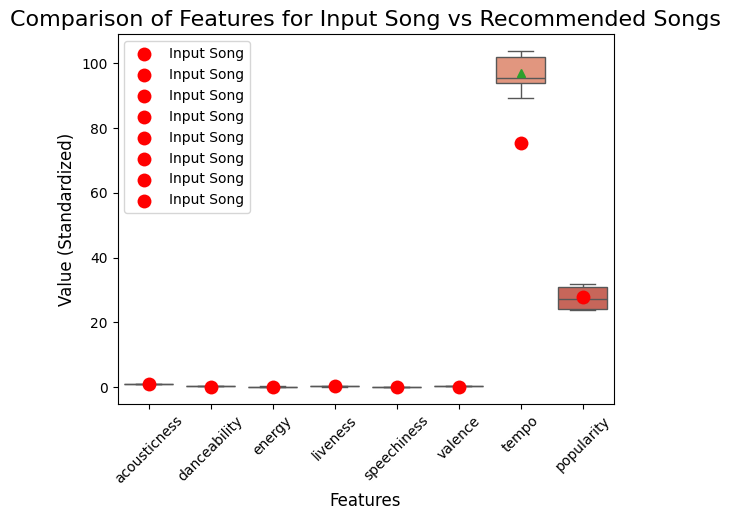

In [ ]:
# Plot perbandingan
sns.boxplot(data=recommended_features, palette="coolwarm", showmeans=True)
sns.stripplot(data=input_features, size=10, color="red", label="Input Song", jitter=False)

plt.title("Comparison of Features for Input Song vs Recommended Songs", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Value (Standardized)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()

##**SAVE RESULT**

In [ ]:
# Menyimpan hasil rekomendasi ke file CSV
output_file = 'personalized_recommendations.csv'
recommendations.to_csv(output_file, index=False)
print(f"Rekomendasi telah disimpan dalam '{output_file}'")

Rekomendasi telah disimpan dalam 'personalized_recommendations.csv'
